In [1]:
!pip install yfinance mplfinance pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.0 MB/s eta 0:00:00


In [6]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import warnings

# Suppress pandas warnings for cleaner output
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

print("Libraries imported successfully.")

Libraries imported successfully.


In [15]:
# Cell 2: Data Loading (Corrected)
print("Fetching 15-minute AAPL data...")
# Fetch a good range of intraday data
df = yf.download(
    'AAPL',
    period='60d',
    interval='15m',
    progress=False
)

# --- FIX: Flatten the column index if it's a MultiIndex ---
# yfinance can return a multi-level index (e.g., ('Close', 'AAPL')). This flattens it.
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

# Use the last 500 periods for a cleaner chart
df = df.iloc[-500:]

# Rename columns to be lowercase, which our indicators expect
df.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"}, inplace=True)

print(f"Data fetched and columns flattened for AAPL. Shape: {df.shape}")
df.head()

Fetching 15-minute AAPL data...


/tmp/ipython-input-715676210.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Data fetched and columns flattened for AAPL. Shape: (500, 5)


Price,close,high,low,open,volume
Datetime,,,,,
2025-09-18 18:30:00+00:00,237.705002,237.946396,237.664993,237.809998,705848
2025-09-18 18:45:00+00:00,237.690002,237.800995,237.570007,237.705002,776590
2025-09-18 19:00:00+00:00,237.619995,237.800003,237.514999,237.690002,818046
2025-09-18 19:15:00+00:00,237.449997,237.725006,237.250107,237.610001,1240217
2025-09-18 19:30:00+00:00,237.789993,237.914307,237.434998,237.455002,1063214


In [16]:
# Cell 3: Indicator Classes

class CandlestickEngulfing:
    """Detects Bullish and Bearish Engulfing patterns."""
    def detect_engulfing(self, df):
        open_s, high_s, low_s, close_s = df['open'].squeeze(), df['high'].squeeze(), df['low'].squeeze(), df['close'].squeeze()
        prev_open, prev_close = open_s.shift(1), close_s.shift(1)

        # Bullish: Current green body engulfs previous red body
        bullish_condition = (close_s > open_s) & (prev_close < prev_open) & (close_s >= prev_open) & (open_s <= prev_close)
        # Bearish: Current red body engulfs previous green body
        bearish_condition = (close_s < open_s) & (prev_close > prev_open) & (close_s <= prev_open) & (open_s >= prev_close)

        return bullish_condition, bearish_condition

class MACDV:
    """Calculates MACD, Signal Line, and Histogram."""
    def __init__(self, fast_period=12, slow_period=26, signal_period=9):
        self.fast_period, self.slow_period, self.signal_period = fast_period, slow_period, signal_period

    def calculate_macdv(self, df):
        close_s = df['close'].squeeze()
        fast_ema = close_s.ewm(span=self.fast_period, adjust=False).mean()
        slow_ema = close_s.ewm(span=self.slow_period, adjust=False).mean()
        macd_line = fast_ema - slow_ema
        signal_line = macd_line.ewm(span=self.signal_period, adjust=False).mean()
        histogram = macd_line - signal_line
        return macd_line, signal_line, histogram

class ADXHistogram:
    """Calculates ADX and Directional Movement Indicators (+DI, -DI)."""
    def __init__(self, adx_length=14, di_length=14):
        self.adx_length, self.di_length = adx_length, di_length

    def calculate_directional_movement(self, df):
        high_s, low_s, close_s = df['high'].squeeze(), df['low'].squeeze(), df['close'].squeeze()
        tr1, tr2, tr3 = high_s - low_s, abs(high_s - close_s.shift(1)), abs(low_s - close_s.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        up_move, down_move = high_s - high_s.shift(1), low_s.shift(1) - low_s
        dm_plus, dm_minus = pd.Series(0.0, index=df.index), pd.Series(0.0, index=df.index)
        plus_mask, minus_mask = (up_move > down_move) & (up_move > 0), (down_move > up_move) & (down_move > 0)
        dm_plus.loc[plus_mask], dm_minus.loc[minus_mask] = up_move.loc[plus_mask], down_move.loc[minus_mask]
        return tr, dm_plus, dm_minus

    def calculate_adx(self, df):
        # Using EWM for smoothing is a common and robust method for ADX in Python
        tr, dm_plus, dm_minus = self.calculate_directional_movement(df)
        tr_smooth = tr.ewm(alpha=1/self.di_length, adjust=False).mean()
        dm_plus_smooth = dm_plus.ewm(alpha=1/self.di_length, adjust=False).mean()
        dm_minus_smooth = dm_minus.ewm(alpha=1/self.di_length, adjust=False).mean()

        di_plus = 100 * (dm_plus_smooth / tr_smooth)
        di_minus = 100 * (dm_minus_smooth / tr_smooth)
        dx = 100 * abs(di_plus - di_minus) / (di_plus + di_minus).replace(0, np.nan)
        adx = dx.ewm(alpha=1/self.adx_length, adjust=False).mean()
        return adx, di_plus, di_minus

print("Indicator classes defined successfully.")

Indicator classes defined successfully.


Found 33 Bullish and 44 Bearish Engulfing patterns.


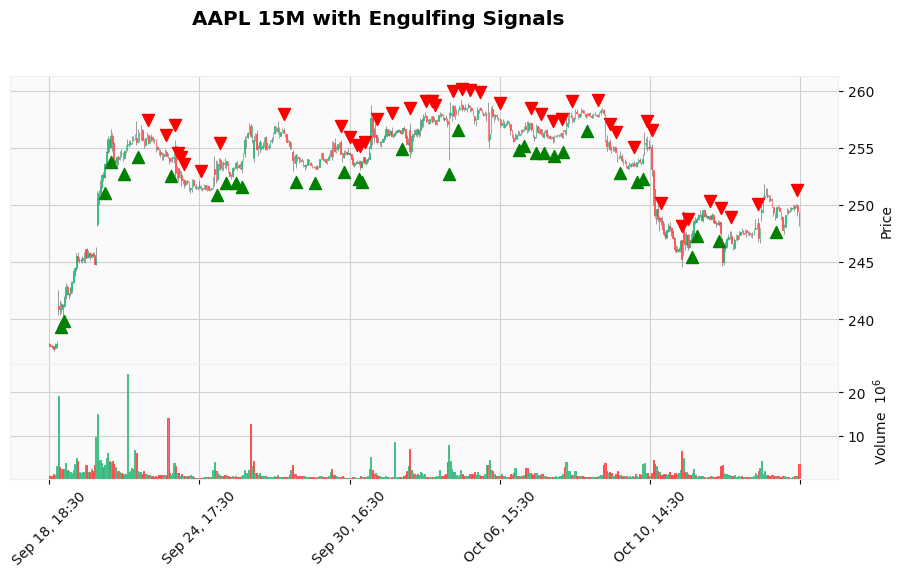

In [17]:
# Cell 4: Applying Indicator 1 - Candlestick Engulfing

# Instantiate and apply the indicator
engulfing_detector = CandlestickEngulfing()
bullish_engulfing, bearish_engulfing = engulfing_detector.detect_engulfing(df)
print(f"Found {bullish_engulfing.sum()} Bullish and {bearish_engulfing.sum()} Bearish Engulfing patterns.")

# Prepare markers for plotting
bullish_markers = np.where(bullish_engulfing, df['low'] * 0.995, np.nan)
bearish_markers = np.where(bearish_engulfing, df['high'] * 1.005, np.nan)

# Create the plot list for mplfinance
add_plots_engulfing = [
    mpf.make_addplot(bullish_markers, type='scatter', marker='^', color='green', markersize=75),
    mpf.make_addplot(bearish_markers, type='scatter', marker='v', color='red', markersize=75)
]

# Plot the chart
mpf.plot(df, type='candle', style='yahoo', title='AAPL 15M with Engulfing Signals',
         addplot=add_plots_engulfing, figratio=(16, 8), volume=True)

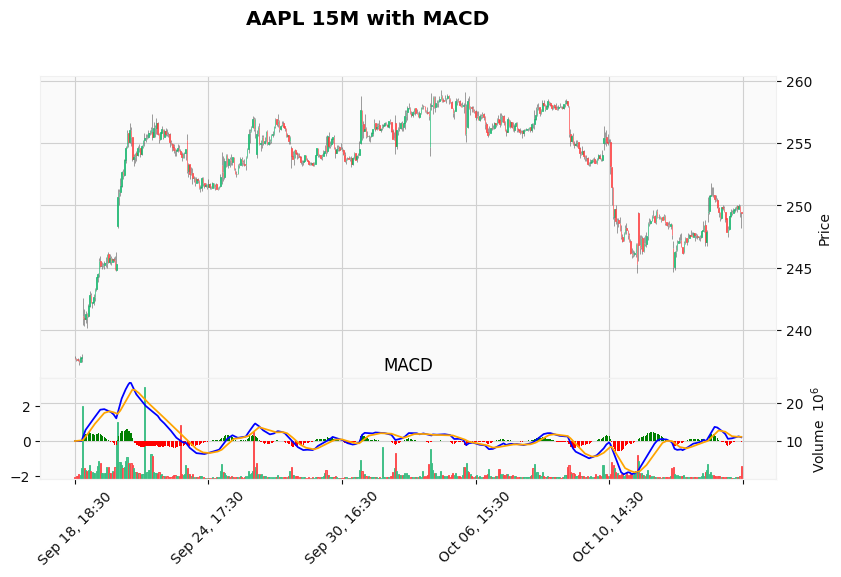

In [18]:
# Cell 5: Applying Indicator 2 - MACD-V

# Instantiate and apply the indicator
macdv_indicator = MACDV()
macd_line, signal_line, macd_hist = macdv_indicator.calculate_macdv(df)

# Prepare the histogram colors
macd_colors = ['green' if val > 0 else 'red' for val in macd_hist]

# Create the plot list for mplfinance, specifying panel=1 for the subplot
add_plots_macdv = [
    mpf.make_addplot(macd_line, panel=1, color='blue', title='MACD'),
    mpf.make_addplot(signal_line, panel=1, color='orange'),
    mpf.make_addplot(macd_hist, type='bar', panel=1, color=macd_colors)
]

# Plot the chart with a subplot for the MACD
mpf.plot(df, type='candle', style='yahoo', title='AAPL 15M with MACD',
         addplot=add_plots_macdv, figratio=(16, 9), panel_ratios=(3, 1), volume=True)

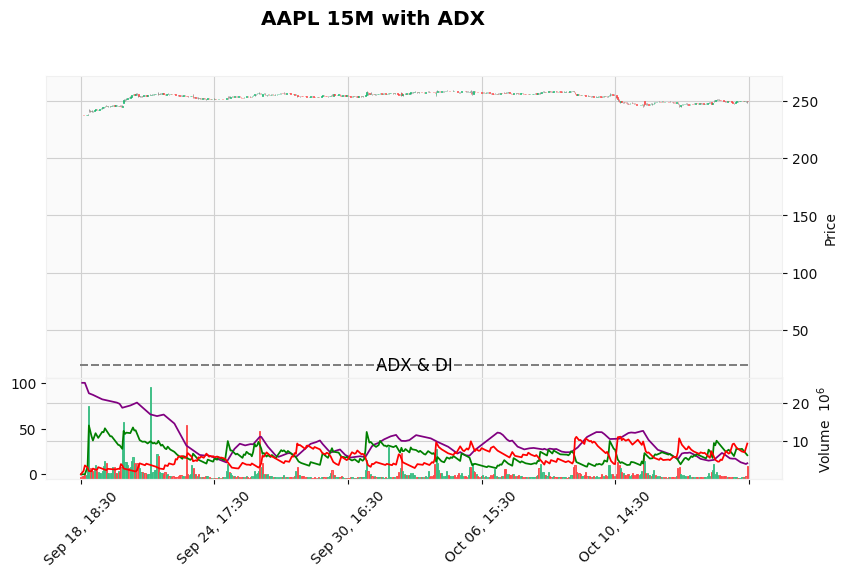

In [19]:
# Cell 6: Applying Indicator 3 - ADX Histogram

# Instantiate and apply the indicator
adx_indicator = ADXHistogram()
adx, di_plus, di_minus = adx_indicator.calculate_adx(df)

# Create the plot list, specifying panel=1 for the subplot
add_plots_adx = [
    mpf.make_addplot(adx, panel=1, color='purple', title='ADX & DI'),
    mpf.make_addplot(di_plus, panel=1, color='green'),
    mpf.make_addplot(di_minus, panel=1, color='red'),
]

# Plot the chart with a subplot for ADX
mpf.plot(df, type='candle', style='yahoo', title='AAPL 15M with ADX',
         addplot=add_plots_adx, figratio=(16, 9), panel_ratios=(3, 1),
         volume=True, hlines=dict(hlines=[20], colors=['gray'], linestyle='--'))

In [20]:
# Cell 7: Merging Indicators & Defining a Strategy

print("Defining the trading strategy by combining indicator signals...")

# 1. Bullish/Bearish Engulfing Pattern (from Cell 4)
# (bullish_engulfing, bearish_engulfing) are already calculated

# 2. ADX Trend Filter (from Cell 6)
is_trending = adx > 20

# 3. MACD Momentum Filter (from Cell 5)
is_macd_bullish = macd_line > signal_line
is_macd_bearish = macd_line < signal_line

# --- Define Strategy Rules ---
# Buy Signal: Bullish engulfing + Trending market + Bullish MACD
buy_strategy_signals = (bullish_engulfing) & (is_trending) & (is_macd_bullish)

# Sell Signal: Bearish engulfing + Trending market + Bearish MACD
sell_strategy_signals = (bearish_engulfing) & (is_trending) & (is_macd_bearish)


print(f"\nFinal Strategy Results:")
print(f"Total Buy signals generated: {buy_strategy_signals.sum()}")
print(f"Total Sell signals generated: {sell_strategy_signals.sum()}")

Defining the trading strategy by combining indicator signals...

Final Strategy Results:
Total Buy signals generated: 19
Total Sell signals generated: 19



Generating the final combined chart...


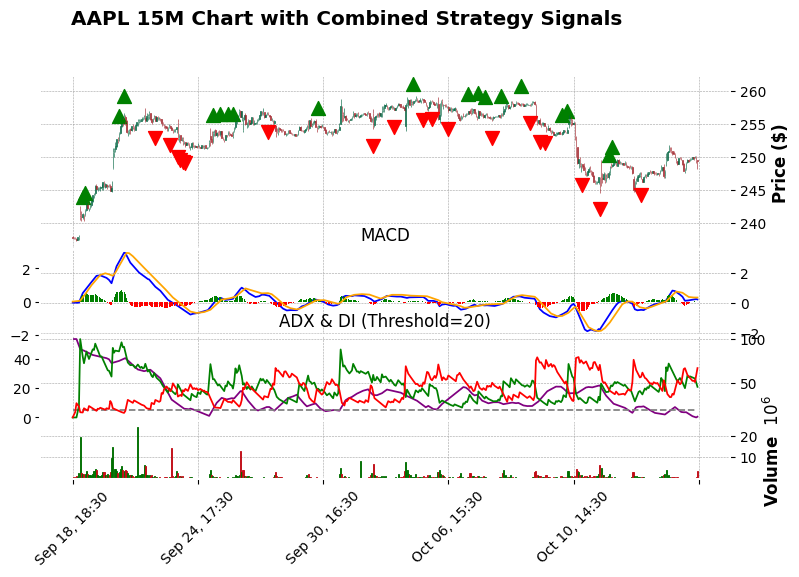

Chart generation complete.


In [32]:
# Cell 8: Final Strategy Visualization

print("\nGenerating the final combined chart...")

# Prepare markers for the final strategy signals
strategy_buy_markers = np.where(buy_strategy_signals, df['high'] * 1.01, np.nan)
strategy_sell_markers = np.where(sell_strategy_signals, df['low'] * 0.99, np.nan)

# Create the comprehensive list of additional plots for all subpanels
final_add_plots = [
    # MACD Subpanel (Panel 1)
    mpf.make_addplot(macd_line, panel=1, color='blue', title='MACD'),
    mpf.make_addplot(signal_line, panel=1, color='orange'),
    mpf.make_addplot(macd_hist, type='bar', panel=1, color=macd_colors),

    # ADX Subpanel (Panel 2)
    mpf.make_addplot(adx, panel=2, color='purple', title='ADX & DI (Threshold=20)'),
    mpf.make_addplot(di_plus, panel=2, color='green'),
    mpf.make_addplot(di_minus, panel=2, color='red'),
    # ADX Threshold Line (added as hline addplot)
    mpf.make_addplot(pd.Series(20, index=df.index), panel=2, color='gray', linestyle='--', type='line'), # Corrected type to 'line'

    # Final Strategy Signals on the main chart (Panel 0)
    mpf.make_addplot(strategy_buy_markers, type='scatter', marker='^', color='green', markersize=100),
    mpf.make_addplot(strategy_sell_markers, type='scatter', marker='v', color='red', markersize=100)
]

# Plot the final, multi-panel chart
mpf.plot(
    df,
    type='candle',
    style='charles',
    title='AAPL 15M Chart with Combined Strategy Signals',
    ylabel='Price ($)',
    figratio=(20, 12),
    panel_ratios=(6, 3, 3, 2),
    addplot=final_add_plots,
    volume=True,
    volume_panel=3
)

print("Chart generation complete.")

In [33]:
# Cell 9: Backtesting Strategy - Setup

print("Setting up backtesting parameters...")

# --- Backtesting Parameters ---
initial_balance = 10000.0  # Starting with $10,000 USD
trade_qty = 5              # Trade 5 shares of AAPL on each signal

# --- State Tracking Variables ---
cash = initial_balance
position = 0  # Current number of shares held
portfolio_value = []  # A list to track the total value (cash + holdings) over time
trades = []  # A list to record all transactions

print(f"Initial Balance: ${initial_balance:,.2f}")
print(f"Trade Quantity: {trade_qty} shares")

Setting up backtesting parameters...
Initial Balance: $10,000.00
Trade Quantity: 5 shares


In [34]:
# Cell 10: Executing the Backtest

print("Running the backtest simulation...")

# Loop through each row (each 15-minute bar) in our DataFrame
for index, row in df.iterrows():

    # At the start of each bar, calculate the current portfolio value and record it
    current_portfolio_value = cash + (position * row['close'])
    portfolio_value.append(current_portfolio_value)

    # --- Trading Logic ---

    # Check for a BUY signal at this timestamp
    if buy_strategy_signals.loc[index]:
        # Check if we have enough cash to buy
        if cash >= trade_qty * row['close']:
            # Execute the buy
            cash -= trade_qty * row['close']
            position += trade_qty
            trade_info = f"BUY: {trade_qty} @ ${row['close']:.2f} on {index.strftime('%Y-%m-%d %H:%M')}"
            trades.append(trade_info)
            print(trade_info)
        else:
            print(f"INFO: Buy signal on {index.strftime('%Y-%m-%d %H:%M')}, but not enough cash.")

    # Check for a SELL signal at this timestamp
    elif sell_strategy_signals.loc[index]:
        # Check if we have enough shares to sell
        if position >= trade_qty:
            # Execute the sell
            cash += trade_qty * row['close']
            position -= trade_qty
            trade_info = f"SELL: {trade_qty} @ ${row['close']:.2f} on {index.strftime('%Y-%m-%d %H:%M')}"
            trades.append(trade_info)
            print(trade_info)
        else:
            print(f"INFO: Sell signal on {index.strftime('%Y-%m-%d %H:%M')}, but no position to sell.")

# After the loop, create a DataFrame to hold the portfolio value over time for plotting
portfolio_df = pd.DataFrame({'value': portfolio_value}, index=df.index)

print("\nBacktest simulation complete.")

Running the backtest simulation...
BUY: 5 @ $241.32 on 2025-09-19 14:00
BUY: 5 @ $241.91 on 2025-09-19 14:30
BUY: 5 @ $253.60 on 2025-09-22 14:45
BUY: 5 @ $256.05 on 2025-09-22 15:45
SELL: 5 @ $255.47 on 2025-09-23 15:30
SELL: 5 @ $254.35 on 2025-09-23 18:30
SELL: 5 @ $252.78 on 2025-09-24 13:30
SELL: 5 @ $252.49 on 2025-09-24 14:00
INFO: Sell signal on 2025-09-24 14:30, but no position to sell.
INFO: Sell signal on 2025-09-24 15:00, but no position to sell.
BUY: 5 @ $253.59 on 2025-09-25 14:00
BUY: 5 @ $253.86 on 2025-09-25 15:30
BUY: 5 @ $253.73 on 2025-09-25 17:00
BUY: 5 @ $253.87 on 2025-09-25 18:00
SELL: 5 @ $256.32 on 2025-09-26 18:30
BUY: 5 @ $254.54 on 2025-09-30 15:30
SELL: 5 @ $254.76 on 2025-10-02 13:30
SELL: 5 @ $257.12 on 2025-10-02 17:45
BUY: 5 @ $258.39 on 2025-10-03 15:00
SELL: 5 @ $258.54 on 2025-10-03 17:00
SELL: 5 @ $258.33 on 2025-10-03 18:45
SELL: 5 @ $257.05 on 2025-10-06 15:30
BUY: 5 @ $256.92 on 2025-10-06 19:30
BUY: 5 @ $256.94 on 2025-10-07 15:00
BUY: 5 @ $256

In [39]:
# Cell 10: Executing the Backtest

print("Running the backtest simulation...")

# Loop through each row (each 15-minute bar) in our DataFrame
# Re-initialize portfolio_value and trades for a clean run each time this cell is executed
portfolio_value = []
trades = []
cash = initial_balance # Ensure cash and position start from initial state
position = 0


for index, row in df.iterrows():

    # --- Trading Logic ---

    # Check for a BUY signal at this timestamp
    if buy_strategy_signals.loc[index]:
        # Check if we have enough cash to buy
        if cash >= trade_qty * row['close']:
            # Execute the buy
            cash -= trade_qty * row['close']
            position += trade_qty
            trade_info = f"BUY: {trade_qty} @ ${row['close']:.2f} on {index.strftime('%Y-%m-%d %H:%M')}"
            trades.append(trade_info)
            print(trade_info)
        else:
            print(f"INFO: Buy signal on {index.strftime('%Y-%m-%d %H:%M')}, but not enough cash.")

    # Check for a SELL signal at this timestamp
    elif sell_strategy_signals.loc[index]:
        # Check if we have enough shares to sell
        if position >= trade_qty:
            # Execute the sell
            cash += trade_qty * row['close']
            position -= trade_qty
            trade_info = f"SELL: {trade_qty} @ ${row['close']:.2f} on {index.strftime('%Y-%m-%d %H:%M')}"
            trades.append(trade_info)
            print(trade_info)
        else:
            print(f"INFO: Sell signal on {index.strftime('%Y-%m-%d %H:%M')}, but no position to sell.")

    # Record the portfolio value *after* checking for trades in this bar
    current_portfolio_value = cash + (position * row['close'])
    portfolio_value.append(current_portfolio_value)


# After the loop, create a DataFrame to hold the portfolio value over time for plotting
# Ensure the index is aligned with the data
portfolio_df = pd.DataFrame({'value': portfolio_value}, index=df.index)

print("\nBacktest simulation complete.")

Running the backtest simulation...
BUY: 5 @ $241.32 on 2025-09-19 14:00
BUY: 5 @ $241.91 on 2025-09-19 14:30
BUY: 5 @ $253.60 on 2025-09-22 14:45
BUY: 5 @ $256.05 on 2025-09-22 15:45
SELL: 5 @ $255.47 on 2025-09-23 15:30
SELL: 5 @ $254.35 on 2025-09-23 18:30
SELL: 5 @ $252.78 on 2025-09-24 13:30
SELL: 5 @ $252.49 on 2025-09-24 14:00
INFO: Sell signal on 2025-09-24 14:30, but no position to sell.
INFO: Sell signal on 2025-09-24 15:00, but no position to sell.
BUY: 5 @ $253.59 on 2025-09-25 14:00
BUY: 5 @ $253.86 on 2025-09-25 15:30
BUY: 5 @ $253.73 on 2025-09-25 17:00
BUY: 5 @ $253.87 on 2025-09-25 18:00
SELL: 5 @ $256.32 on 2025-09-26 18:30
BUY: 5 @ $254.54 on 2025-09-30 15:30
SELL: 5 @ $254.76 on 2025-10-02 13:30
SELL: 5 @ $257.12 on 2025-10-02 17:45
BUY: 5 @ $258.39 on 2025-10-03 15:00
SELL: 5 @ $258.54 on 2025-10-03 17:00
SELL: 5 @ $258.33 on 2025-10-03 18:45
SELL: 5 @ $257.05 on 2025-10-06 15:30
BUY: 5 @ $256.92 on 2025-10-06 19:30
BUY: 5 @ $256.94 on 2025-10-07 15:00
BUY: 5 @ $256

Generating equity curve chart...


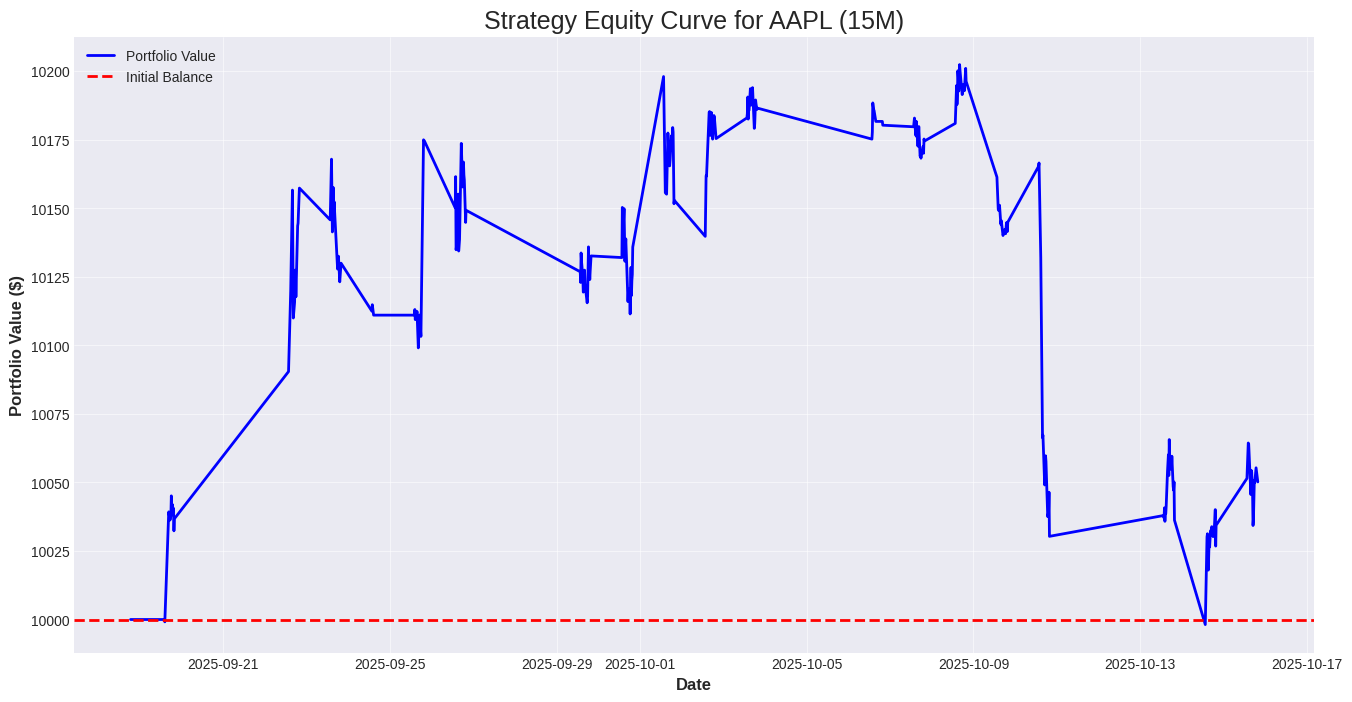

In [40]:
# Cell 12: Visualizing the Equity Curve
import matplotlib.pyplot as plt

print("Generating equity curve chart...")

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(16, 8))

# Plot the portfolio value over time
plt.plot(portfolio_df.index, portfolio_df['value'], label='Portfolio Value', color='blue', linewidth=2)

# Add a horizontal line for the initial balance to see the breakeven point
plt.axhline(y=initial_balance, color='red', linestyle='--', label='Initial Balance')

plt.title('Strategy Equity Curve for AAPL (15M)', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [43]:
# Cell 10: Trade-Based Backtest & Win Rate Calculation (REPLACE old Cell 10)

print("Running TRADE-BASED backtest simulation to calculate Win Rate...")

# --- Backtesting Parameters ---
initial_balance = 10000.0
trade_qty = 5

# --- State Tracking Variables ---
cash = initial_balance
position = 0
portfolio_value = []
trades_log = [] # To store P&L for each round-trip trade

# --- New variables for "in-or-out" logic and win rate ---
in_position = False
entry_price = 0
win_count = 0
loss_count = 0

# Loop through each 15-minute bar
for index, row in df.iterrows():

    # Always calculate the current portfolio value at the start of the bar
    current_portfolio_value = cash + (position * row['close'])
    portfolio_value.append(current_portfolio_value)

    # --- Trading Logic (In-or-Out) ---

    # Check for a BUY signal and ensure we are NOT already in a position
    if buy_strategy_signals.loc[index] and not in_position:
        if cash >= trade_qty * row['close']:
            # Execute the buy
            cash -= trade_qty * row['close']
            position = trade_qty
            entry_price = row['close'] # Log the entry price
            in_position = True
            print(f"ENTER LONG: {trade_qty} @ ${row['close']:.2f} on {index.strftime('%Y-%m-%d %H:%M')}")

    # Check for a SELL signal and ensure we ARE in a position
    elif sell_strategy_signals.loc[index] and in_position:
        # Execute the sell
        cash += position * row['close']
        exit_price = row['close']

        # Calculate P&L for this round-trip trade
        pnl = (exit_price - entry_price) * position
        trades_log.append(pnl)

        # Increment win/loss counters
        if pnl > 0:
            win_count += 1
        else:
            loss_count += 1

        # Reset position
        position = 0
        in_position = False
        print(f"EXIT LONG:  {trade_qty} @ ${row['close']:.2f} on {index.strftime('%Y-%m-%d %H:%M')} | P&L: ${pnl:.2f}")

# Create a DataFrame to hold the portfolio value for plotting
portfolio_df = pd.DataFrame({'value': portfolio_value}, index=df.index)

# Calculate final win rate
total_closed_trades = win_count + loss_count
win_rate = (win_count / total_closed_trades) * 100 if total_closed_trades > 0 else 0

print("\nBacktest simulation complete.")

Running TRADE-BASED backtest simulation to calculate Win Rate...
ENTER LONG: 5 @ $241.32 on 2025-09-19 14:00
EXIT LONG:  5 @ $255.47 on 2025-09-23 15:30 | P&L: $70.74
ENTER LONG: 5 @ $253.59 on 2025-09-25 14:00
EXIT LONG:  5 @ $256.32 on 2025-09-26 18:30 | P&L: $13.65
ENTER LONG: 5 @ $254.54 on 2025-09-30 15:30
EXIT LONG:  5 @ $254.76 on 2025-10-02 13:30 | P&L: $1.06
ENTER LONG: 5 @ $258.39 on 2025-10-03 15:00
EXIT LONG:  5 @ $258.54 on 2025-10-03 17:00 | P&L: $0.75
ENTER LONG: 5 @ $256.92 on 2025-10-06 19:30
EXIT LONG:  5 @ $255.84 on 2025-10-07 17:45 | P&L: $-5.42
ENTER LONG: 5 @ $256.54 on 2025-10-07 19:30
EXIT LONG:  5 @ $257.80 on 2025-10-08 18:45 | P&L: $6.30
ENTER LONG: 5 @ $253.81 on 2025-10-09 18:45
EXIT LONG:  5 @ $248.61 on 2025-10-10 16:15 | P&L: $-25.99
ENTER LONG: 5 @ $247.53 on 2025-10-13 15:00
EXIT LONG:  5 @ $246.70 on 2025-10-14 15:00 | P&L: $-4.15

Backtest simulation complete.



Generating final performance visualizations...


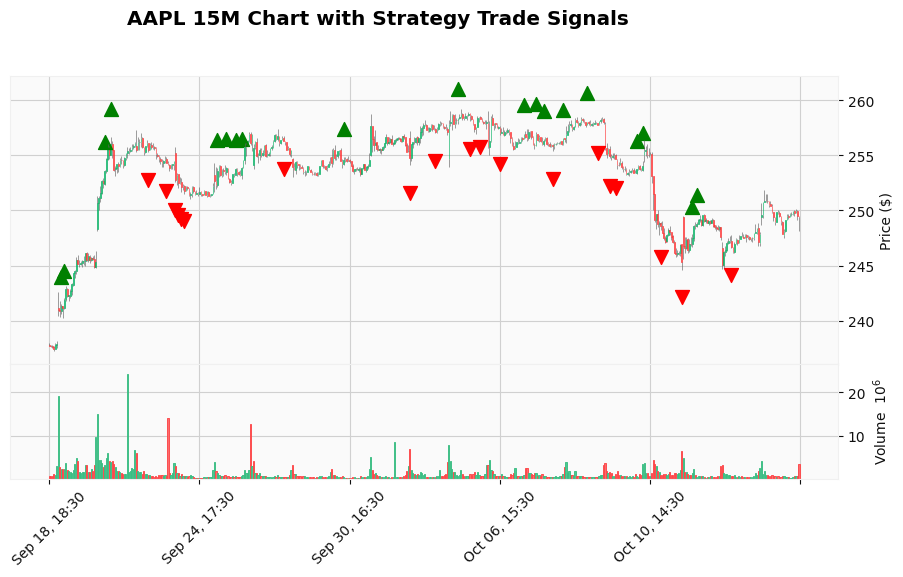

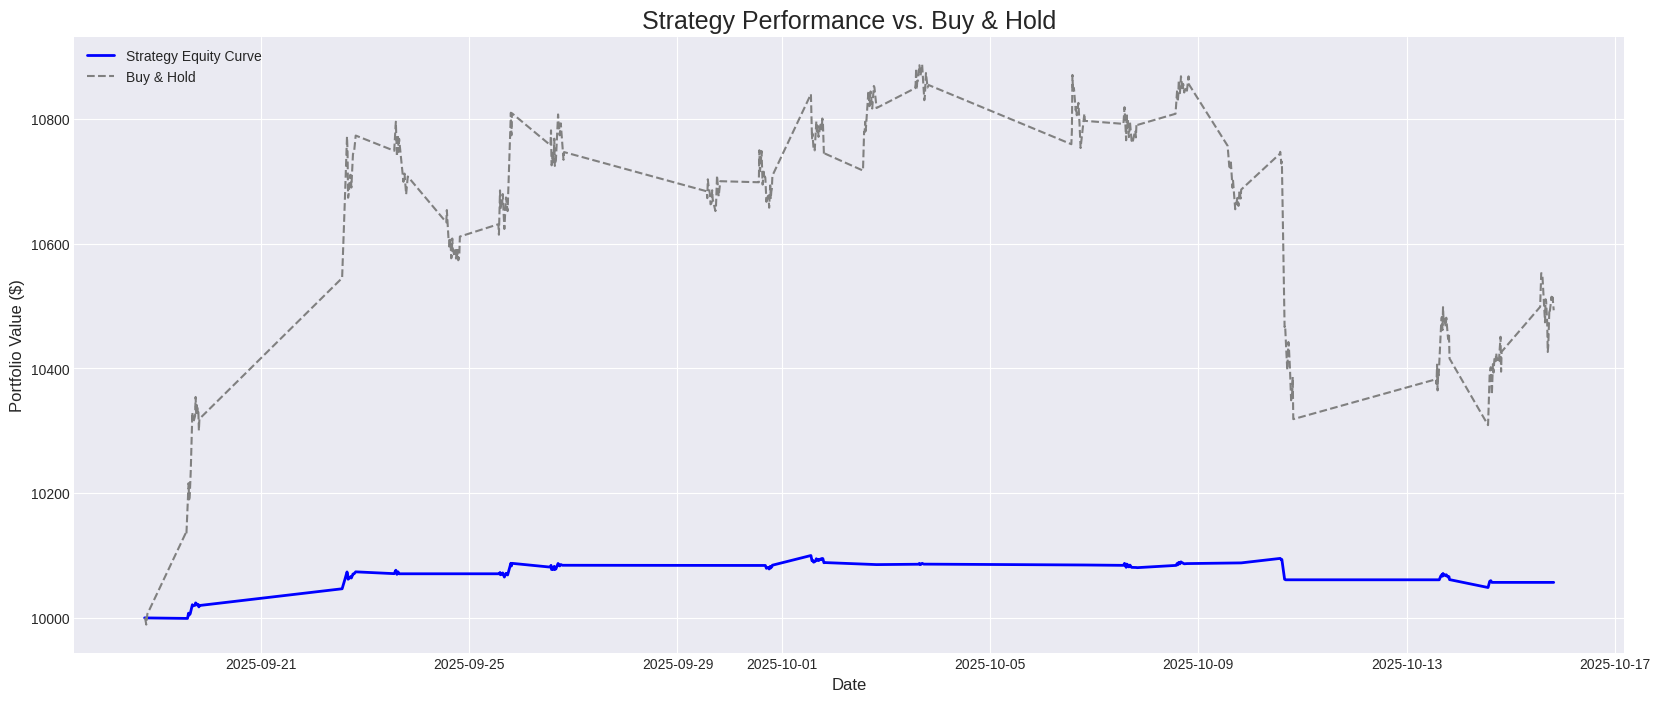

In [45]:

import matplotlib.pyplot as plt

print("\nGenerating final performance visualizations...")

# --- Visualization 1: Candlestick Chart with Strategy Signals ---

# Prepare markers for the final strategy signals
strategy_buy_markers = np.where(buy_strategy_signals, df['high'] * 1.01, np.nan)
strategy_sell_markers = np.where(sell_strategy_signals, df['low'] * 0.99, np.nan)

# Create the plot list for mplfinance
final_add_plots = [
    mpf.make_addplot(strategy_buy_markers, type='scatter', marker='^', color='green', markersize=100),
    mpf.make_addplot(strategy_sell_markers, type='scatter', marker='v', color='red', markersize=100)
]

# Plot the candlestick chart with signals
mpf.plot(
    df,
    type='candle',
    style='yahoo',
    title='AAPL 15M Chart with Strategy Trade Signals',
    ylabel='Price ($)',
    figratio=(20, 10),
    addplot=final_add_plots,
    volume=True
)


# --- Visualization 2: Portfolio Equity Curve ---

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the portfolio value over time
ax.plot(portfolio_df.index, portfolio_df['value'], label='Strategy Equity Curve', color='blue', linewidth=2)

# Plot Buy and Hold for comparison
ax.plot(portfolio_df.index, (df['close'] / df['close'].iloc[0]) * initial_balance, label='Buy & Hold', color='grey', linestyle='--')

ax.set_title('Strategy Performance vs. Buy & Hold', fontsize=18)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value ($)', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True)

plt.show()